In [41]:
data_folder = "./data"
dataset_name = "risk_factors_cervical_cancer.csv"

import pandas as pd
import numpy as np

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

import sys

np.set_printoptions(threshold=sys.maxsize)

In [90]:
# Import data

data = pd.read_csv(data_folder + "/" + dataset_name)

# Decision: ANY positive test, Hinselmann, Schiller, Citology, 
# or Biopsy, will be considered a positive result by this model.
# Cervical Cancer may be symptomless - erring on the side of 
# caution increases the value of this model. 
#
# Create the class column and append it to data before we do
# anything else. 
data_class = []
data_rows, data_cols = data.shape
data_positives = 0 # for fun
data_negatives = 0
for i in range(0, data_rows):
    row = data.iloc[i]
    if((row["Hinselmann"] + row["Schiller"] + row["Citology"] + row["Biopsy"]) > 0):
        data_class.append(1)
        data_positives = data_positives + 1
    else:
        data_class.append(0)
        data_negatives = data_negatives + 1
    
data["class"] = data_class
data

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy,class
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,1,0,1,0,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0,0
5,42,3.0,23.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0,0
6,51,3.0,17.0,6.0,1.0,34.0,3.4,0.0,0.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,1,1,0,1,1
7,26,1.0,26.0,3.0,0.0,0.0,0.0,1.0,2.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0,0
8,45,1.0,20.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,1,0,1,1,0,0,0,0,0
9,44,3.0,15.0,?,1.0,1.266972909,2.8,0.0,0.0,?,?,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0,0


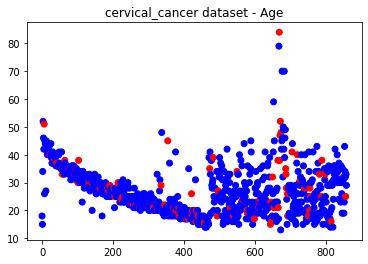

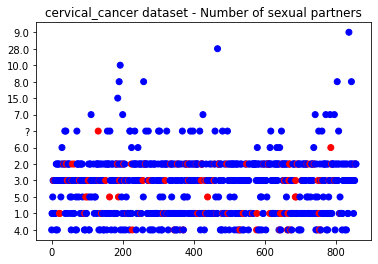

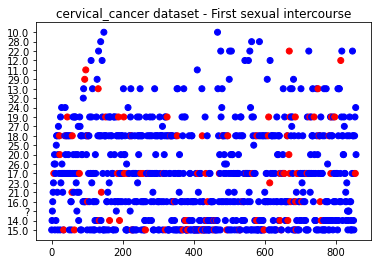

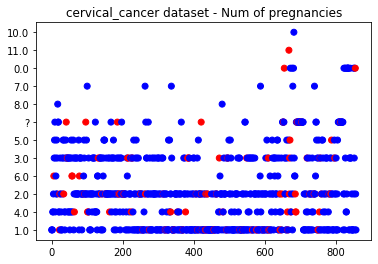

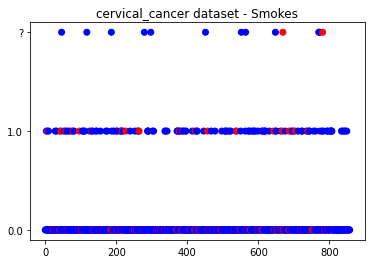

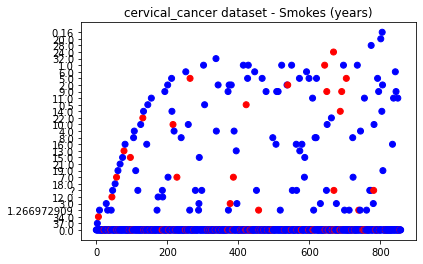

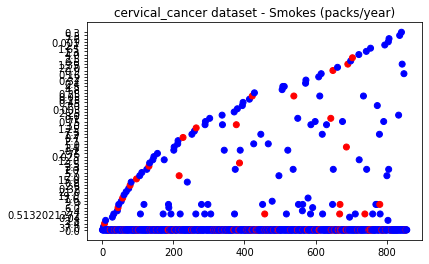

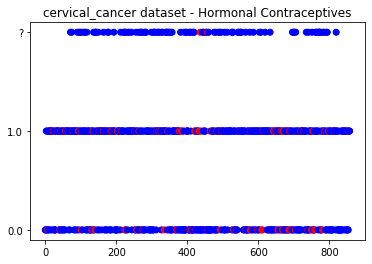

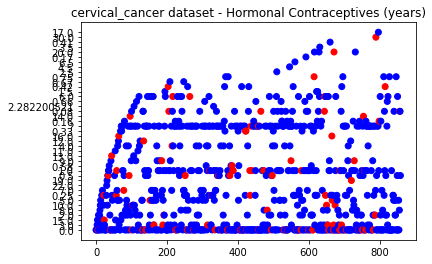

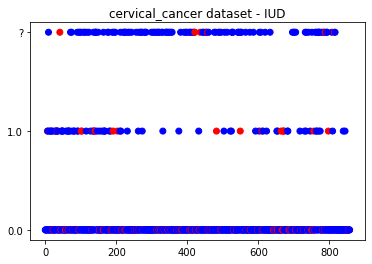

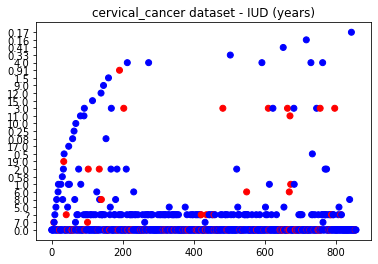

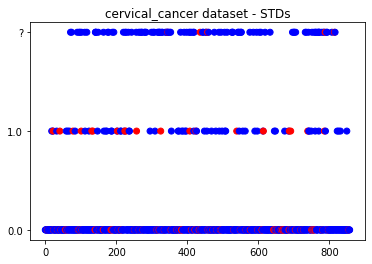

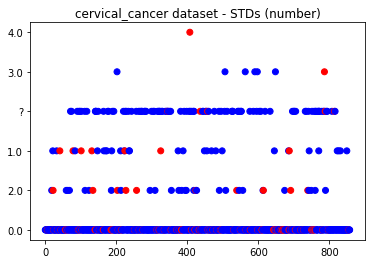

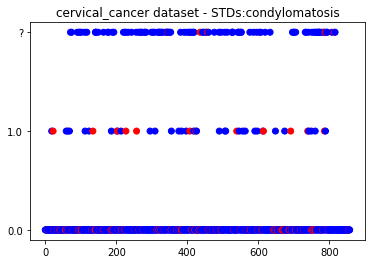

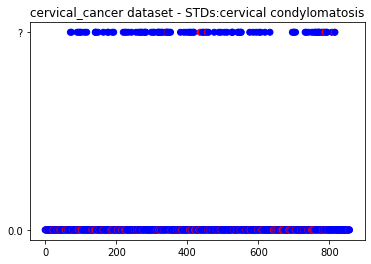

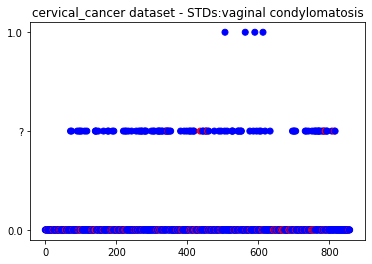

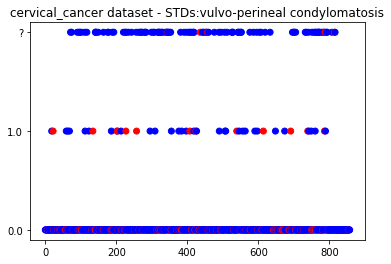

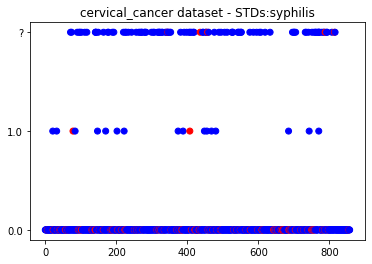

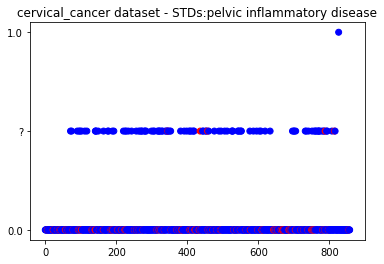

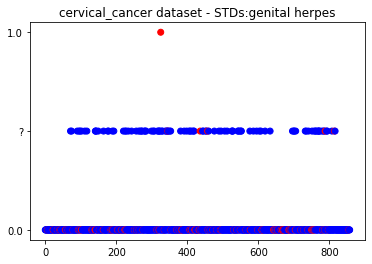

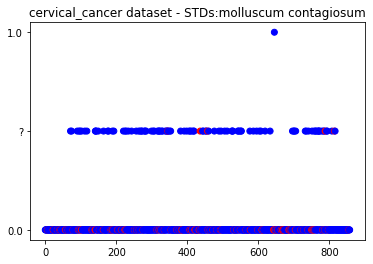

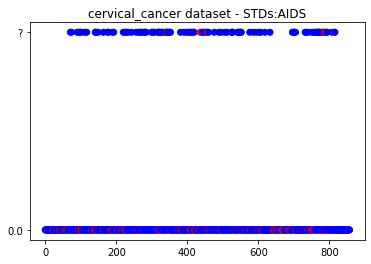

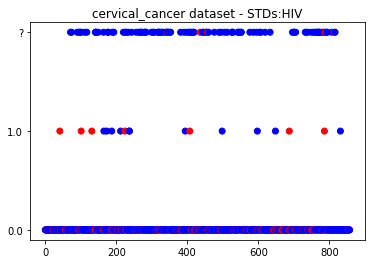

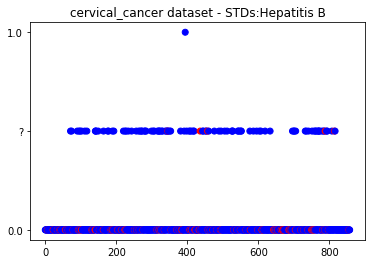

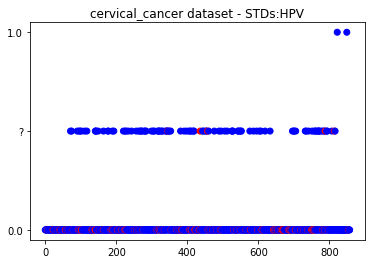

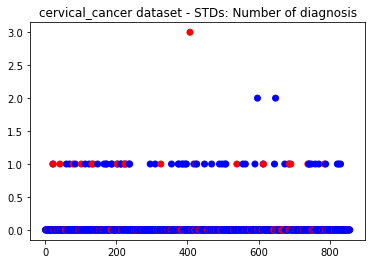

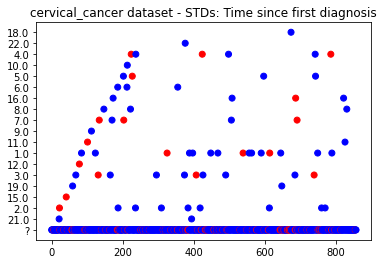

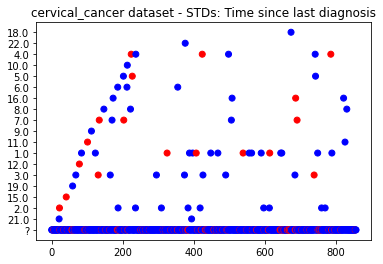

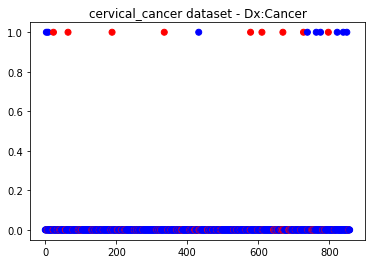

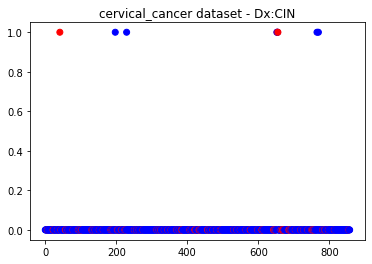

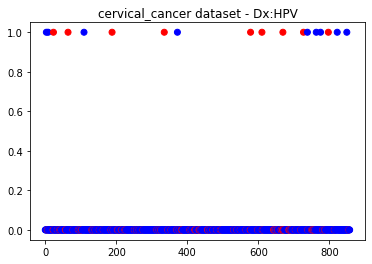

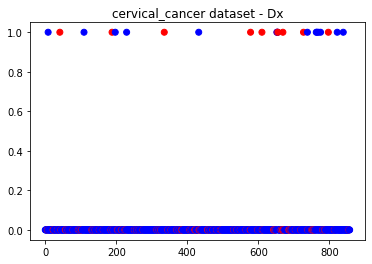

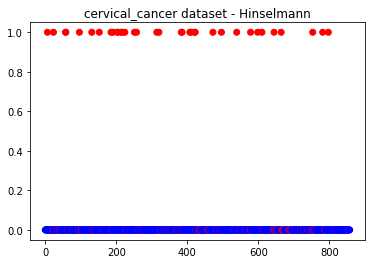

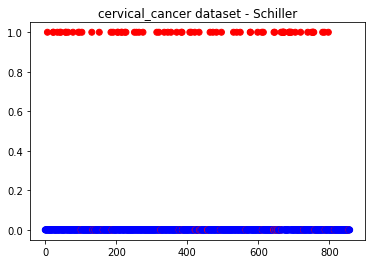

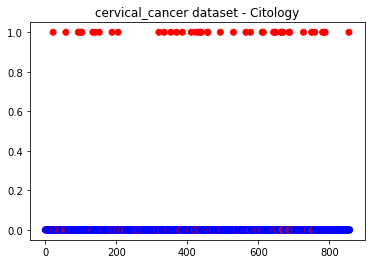

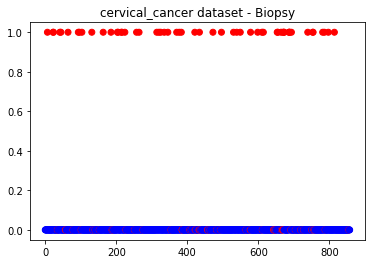

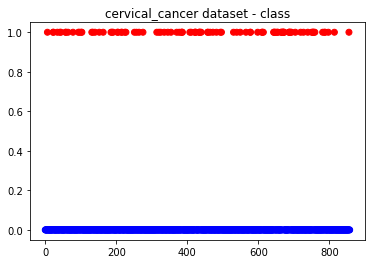

In [16]:
# Data Analysis - Graphing

import matplotlib.pyplot as plt

data_colors = {0:"blue", 1:"red"}

def graph_attribute(data, dataset_name, attribute, solution):
    plt.title(dataset_name + " dataset - " + attribute)
    plt.scatter(data.index, data[attribute], color=data[solution].map(data_colors))
    plt.show()

for column in data:
    graph_attribute(data, "cervical_cancer", column, "class")

In [26]:
data_positives, data_negatives

data.shape

(858, 37)

In [91]:
# Data Preprocessing - X and Y

data_edited = data.copy()

# Remove columns for Hinselmann, Schiller, Citology, Biopsy,
# STD: Time since first diagnosis, and STD: Time since last
# diagnosis.
data_edited = data_edited.drop("Hinselmann", axis=1)
data_edited = data_edited.drop("Schiller", axis=1)
data_edited = data_edited.drop("Citology", axis=1)
data_edited = data_edited.drop("Biopsy", axis=1)
data_edited = data_edited.drop("STDs: Time since first diagnosis", axis=1)
data_edited = data_edited.drop("STDs: Time since last diagnosis", axis=1)

data_numpy = data_edited.to_numpy()

data_rows, data_cols = data_numpy.shape

X = data_numpy[:,0:(data_cols-1)]
Y = data_numpy[:,(data_cols-1)].astype("float")

X.shape

(858, 30)

In [92]:
# Data Preprocessing - Rows With Missing Data

# Retain an array of rows to delete for displaying our model's
# predictions later on. 
X_rows_to_delete = []

X_rows, X_cols = X.shape

# Iterate from bottom to top. 
for i in range(X_rows-1,-1,-1):
    delete_row = False
    row = X[i]
    for item in row:
        if item == "?":
            X_rows_to_delete.append(i)
            delete_row = True
            break
    if delete_row:
        X = np.delete(X, i, 0)
        Y = np.delete(Y, i, 0) # Remove from the solution as well. 

X = X.astype("float")

(668,)

In [179]:
# Model Spot Check - Define Baseline Models (That we know)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Neural Network
epochs = 500
batch_size = 10

# K Nearest Neighbor
n_neighbors = 100
metric = "manhattan"

X_rows, X_cols = X.shape

def baseline_nn_model():
    model = Sequential()
    model.add(Dense(18,input_dim=X_cols, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

from sklearn.neighbors import KNeighborsClassifier

def baseline_knn_model():
    model = KNeighborsClassifier(n_neighbors = n_neighbors, metric=metric)
    return model

from sklearn.naive_bayes import GaussianNB

def baseline_gnb_model():
    model = GaussianNB()
    return model

In [180]:
# Model Spot Check - Define Pipelines

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

estimators_nn = []
estimators_nn.append(("standardize", StandardScaler()))
estimators_nn.append(("clf", KerasClassifier(build_fn=baseline_nn_model, epochs=epochs, batch_size=batch_size)))
pipeline_nn = Pipeline(estimators_nn)
kfold_nn = KFold(n_splits=10, shuffle=True)

estimators_knn = []
estimators_knn.append(("standardize", StandardScaler()))
estimators_knn.append(("clf", baseline_knn_model()))
pipeline_knn = Pipeline(estimators_knn)
kfold_knn = KFold(n_splits=10, shuffle=True)

estimators_gnb = []
estimators_gnb.append(("standardize", StandardScaler()))
estimators_gnb.append(("clf", baseline_gnb_model()))
pipeline_gnb = Pipeline(estimators_gnb)
kfold_gnb = KFold(n_splits=10, shuffle=True)

In [181]:
# Model Spot Check - Evaluate Neural Network

results_nn = cross_val_score(pipeline_nn, X, Y, cv=kfold_nn)

Epoch 1/500
61/61 [==============================] - 0s 1ms/step - loss: 0.7200 - accuracy: 0.5324
Epoch 2/500
61/61 [==============================] - 0s 1ms/step - loss: 0.5398 - accuracy: 0.8286
Epoch 3/500
61/61 [==============================] - 0s 1ms/step - loss: 0.4396 - accuracy: 0.8636
Epoch 4/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3932 - accuracy: 0.8702
Epoch 5/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3726 - accuracy: 0.8735
Epoch 6/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3606 - accuracy: 0.8752
Epoch 7/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3530 - accuracy: 0.8785
Epoch 8/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3476 - accuracy: 0.8785
Epoch 9/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3436 - accuracy: 0.8802
Epoch 10/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3403 - accuracy: 0.8785
Epoch 11/

61/61 [==============================] - 0s 1ms/step - loss: 0.2707 - accuracy: 0.9002
Epoch 83/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2690 - accuracy: 0.9035
Epoch 84/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2672 - accuracy: 0.9035
Epoch 85/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2671 - accuracy: 0.9052
Epoch 86/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2660 - accuracy: 0.9018
Epoch 87/500
61/61 [==============================] - 0s 992us/step - loss: 0.2652 - accuracy: 0.9068
Epoch 88/500
61/61 [==============================] - 0s 986us/step - loss: 0.2646 - accuracy: 0.9052
Epoch 89/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2645 - accuracy: 0.9035
Epoch 90/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2637 - accuracy: 0.9052
Epoch 91/500
61/61 [==============================] - 0s 996us/step - loss: 0.2635 - accuracy: 0.9052
Epoch 9

61/61 [==============================] - 0s 994us/step - loss: 0.2361 - accuracy: 0.9168
Epoch 163/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2338 - accuracy: 0.9168
Epoch 164/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2340 - accuracy: 0.9168
Epoch 165/500
61/61 [==============================] - 0s 995us/step - loss: 0.2340 - accuracy: 0.9201
Epoch 166/500
61/61 [==============================] - 0s 973us/step - loss: 0.2337 - accuracy: 0.9185
Epoch 167/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2321 - accuracy: 0.9235
Epoch 168/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2332 - accuracy: 0.9185
Epoch 169/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2315 - accuracy: 0.9185
Epoch 170/500
61/61 [==============================] - 0s 991us/step - loss: 0.2309 - accuracy: 0.9235
Epoch 171/500
61/61 [==============================] - 0s 965us/step - loss: 0.2317 - accuracy: 0

61/61 [==============================] - 0s 1ms/step - loss: 0.2126 - accuracy: 0.9218
Epoch 243/500
61/61 [==============================] - 0s 980us/step - loss: 0.2105 - accuracy: 0.9251
Epoch 244/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2112 - accuracy: 0.9301
Epoch 245/500
61/61 [==============================] - 0s 988us/step - loss: 0.2116 - accuracy: 0.9251
Epoch 246/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2115 - accuracy: 0.9285
Epoch 247/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2120 - accuracy: 0.9301
Epoch 248/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2115 - accuracy: 0.9268
Epoch 249/500
61/61 [==============================] - 0s 972us/step - loss: 0.2116 - accuracy: 0.9251
Epoch 250/500
61/61 [==============================] - 0s 985us/step - loss: 0.2098 - accuracy: 0.9268
Epoch 251/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2104 - accuracy: 0.9

61/61 [==============================] - 0s 998us/step - loss: 0.1992 - accuracy: 0.9334
Epoch 323/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1958 - accuracy: 0.9368
Epoch 324/500
61/61 [==============================] - 0s 984us/step - loss: 0.1959 - accuracy: 0.9334
Epoch 325/500
61/61 [==============================] - 0s 979us/step - loss: 0.1954 - accuracy: 0.9318
Epoch 326/500
61/61 [==============================] - 0s 993us/step - loss: 0.1952 - accuracy: 0.9351
Epoch 327/500
61/61 [==============================] - 0s 974us/step - loss: 0.1952 - accuracy: 0.9334
Epoch 328/500
61/61 [==============================] - 0s 969us/step - loss: 0.1949 - accuracy: 0.9318
Epoch 329/500
61/61 [==============================] - 0s 984us/step - loss: 0.1948 - accuracy: 0.9351
Epoch 330/500
61/61 [==============================] - 0s 967us/step - loss: 0.1951 - accuracy: 0.9301
Epoch 331/500
61/61 [==============================] - 0s 973us/step - loss: 0.1943 - acc

61/61 [==============================] - 0s 991us/step - loss: 0.1903 - accuracy: 0.9351
Epoch 403/500
61/61 [==============================] - 0s 991us/step - loss: 0.1858 - accuracy: 0.9301
Epoch 404/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1805 - accuracy: 0.9368
Epoch 405/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1807 - accuracy: 0.9368
Epoch 406/500
61/61 [==============================] - 0s 974us/step - loss: 0.1811 - accuracy: 0.9384
Epoch 407/500
61/61 [==============================] - 0s 992us/step - loss: 0.1808 - accuracy: 0.9368
Epoch 408/500
61/61 [==============================] - 0s 983us/step - loss: 0.1798 - accuracy: 0.9384
Epoch 409/500
61/61 [==============================] - 0s 993us/step - loss: 0.1824 - accuracy: 0.9384
Epoch 410/500
61/61 [==============================] - 0s 976us/step - loss: 0.1807 - accuracy: 0.9368
Epoch 411/500
61/61 [==============================] - 0s 978us/step - loss: 0.1806 - accur

61/61 [==============================] - 0s 1ms/step - loss: 0.1692 - accuracy: 0.9401
Epoch 483/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1702 - accuracy: 0.9384
Epoch 484/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1697 - accuracy: 0.9401
Epoch 485/500
61/61 [==============================] - 0s 985us/step - loss: 0.1688 - accuracy: 0.9401
Epoch 486/500
61/61 [==============================] - 0s 966us/step - loss: 0.1703 - accuracy: 0.9401
Epoch 487/500
61/61 [==============================] - 0s 989us/step - loss: 0.1797 - accuracy: 0.9351
Epoch 488/500
61/61 [==============================] - 0s 990us/step - loss: 0.1727 - accuracy: 0.9401
Epoch 489/500
61/61 [==============================] - 0s 984us/step - loss: 0.1692 - accuracy: 0.9384
Epoch 490/500
61/61 [==============================] - 0s 983us/step - loss: 0.1691 - accuracy: 0.9401
Epoch 491/500
61/61 [==============================] - 0s 995us/step - loss: 0.1698 - accurac

61/61 [==============================] - 0s 1ms/step - loss: 0.2895 - accuracy: 0.8902
Epoch 63/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2890 - accuracy: 0.8968
Epoch 64/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2881 - accuracy: 0.8968
Epoch 65/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2893 - accuracy: 0.8952
Epoch 66/500
61/61 [==============================] - 0s 986us/step - loss: 0.2872 - accuracy: 0.8985
Epoch 67/500
61/61 [==============================] - 0s 977us/step - loss: 0.2864 - accuracy: 0.8952
Epoch 68/500
61/61 [==============================] - 0s 977us/step - loss: 0.2850 - accuracy: 0.8952
Epoch 69/500
61/61 [==============================] - 0s 982us/step - loss: 0.2840 - accuracy: 0.8985
Epoch 70/500
61/61 [==============================] - 0s 994us/step - loss: 0.2851 - accuracy: 0.8952
Epoch 71/500
61/61 [==============================] - 0s 982us/step - loss: 0.2831 - accuracy: 0.8952
E

61/61 [==============================] - 0s 980us/step - loss: 0.2528 - accuracy: 0.9068
Epoch 143/500
61/61 [==============================] - 0s 990us/step - loss: 0.2522 - accuracy: 0.9052
Epoch 144/500
61/61 [==============================] - 0s 998us/step - loss: 0.2519 - accuracy: 0.9085
Epoch 145/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2510 - accuracy: 0.9068
Epoch 146/500
61/61 [==============================] - 0s 981us/step - loss: 0.2506 - accuracy: 0.9085
Epoch 147/500
61/61 [==============================] - 0s 973us/step - loss: 0.2505 - accuracy: 0.9068
Epoch 148/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2499 - accuracy: 0.9068
Epoch 149/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2497 - accuracy: 0.9052
Epoch 150/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2494 - accuracy: 0.9068
Epoch 151/500
61/61 [==============================] - 0s 992us/step - loss: 0.2485 - accuracy:

61/61 [==============================] - 0s 1ms/step - loss: 0.2300 - accuracy: 0.9185
Epoch 223/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2295 - accuracy: 0.9168
Epoch 224/500
61/61 [==============================] - 0s 991us/step - loss: 0.2291 - accuracy: 0.9135
Epoch 225/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2292 - accuracy: 0.9185
Epoch 226/500
61/61 [==============================] - 0s 979us/step - loss: 0.2286 - accuracy: 0.9185
Epoch 227/500
61/61 [==============================] - 0s 972us/step - loss: 0.2293 - accuracy: 0.9185
Epoch 228/500
61/61 [==============================] - 0s 998us/step - loss: 0.2289 - accuracy: 0.9135
Epoch 229/500
61/61 [==============================] - 0s 993us/step - loss: 0.2287 - accuracy: 0.9151
Epoch 230/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2278 - accuracy: 0.9185
Epoch 231/500
61/61 [==============================] - 0s 973us/step - loss: 0.2278 - accuracy:

61/61 [==============================] - 0s 1ms/step - loss: 0.2155 - accuracy: 0.9235
Epoch 303/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2146 - accuracy: 0.9251
Epoch 304/500
61/61 [==============================] - 0s 2ms/step - loss: 0.2180 - accuracy: 0.9268
Epoch 305/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2153 - accuracy: 0.9251
Epoch 306/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2142 - accuracy: 0.9268
Epoch 307/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2147 - accuracy: 0.9301
Epoch 308/500
61/61 [==============================] - 0s 977us/step - loss: 0.2145 - accuracy: 0.9268
Epoch 309/500
61/61 [==============================] - 0s 965us/step - loss: 0.2137 - accuracy: 0.9285
Epoch 310/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2147 - accuracy: 0.9251
Epoch 311/500
61/61 [==============================] - 0s 991us/step - loss: 0.2142 - accuracy: 0.926

61/61 [==============================] - 0s 1ms/step - loss: 0.2035 - accuracy: 0.9318
Epoch 383/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2023 - accuracy: 0.9334
Epoch 384/500
61/61 [==============================] - 0s 983us/step - loss: 0.2026 - accuracy: 0.9334
Epoch 385/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2024 - accuracy: 0.9301
Epoch 386/500
61/61 [==============================] - 0s 995us/step - loss: 0.2036 - accuracy: 0.9318
Epoch 387/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2124 - accuracy: 0.9268
Epoch 388/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2035 - accuracy: 0.9301
Epoch 389/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2026 - accuracy: 0.9334
Epoch 390/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2025 - accuracy: 0.9285
Epoch 391/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2032 - accuracy: 0.9318


61/61 [==============================] - 0s 1ms/step - loss: 0.1945 - accuracy: 0.9301
Epoch 463/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1931 - accuracy: 0.9334
Epoch 464/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1947 - accuracy: 0.9318
Epoch 465/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1956 - accuracy: 0.9301
Epoch 466/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1937 - accuracy: 0.9351
Epoch 467/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1946 - accuracy: 0.9334
Epoch 468/500
61/61 [==============================] - 0s 999us/step - loss: 0.1939 - accuracy: 0.9334
Epoch 469/500
61/61 [==============================] - 0s 962us/step - loss: 0.1941 - accuracy: 0.9318
Epoch 470/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1936 - accuracy: 0.9318
Epoch 471/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1939 - accuracy: 0.9301


61/61 [==============================] - 0s 994us/step - loss: 0.2985 - accuracy: 0.8902
Epoch 43/500
61/61 [==============================] - 0s 994us/step - loss: 0.2983 - accuracy: 0.8952
Epoch 44/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2973 - accuracy: 0.8902
Epoch 45/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2973 - accuracy: 0.8952
Epoch 46/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2970 - accuracy: 0.8918
Epoch 47/500
61/61 [==============================] - 0s 974us/step - loss: 0.2958 - accuracy: 0.8935
Epoch 48/500
61/61 [==============================] - 0s 988us/step - loss: 0.2963 - accuracy: 0.8935
Epoch 49/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2944 - accuracy: 0.8902
Epoch 50/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2969 - accuracy: 0.8918
Epoch 51/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2943 - accuracy: 0.8935
Epoch

61/61 [==============================] - 0s 988us/step - loss: 0.2627 - accuracy: 0.8985
Epoch 124/500
61/61 [==============================] - 0s 998us/step - loss: 0.2619 - accuracy: 0.9002
Epoch 125/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2617 - accuracy: 0.8985
Epoch 126/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2619 - accuracy: 0.9002
Epoch 127/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2612 - accuracy: 0.8985
Epoch 128/500
61/61 [==============================] - 0s 994us/step - loss: 0.2606 - accuracy: 0.9018
Epoch 129/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2615 - accuracy: 0.8985
Epoch 130/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2598 - accuracy: 0.8985
Epoch 131/500
61/61 [==============================] - 0s 1000us/step - loss: 0.2616 - accuracy: 0.9002
Epoch 132/500
61/61 [==============================] - 0s 995us/step - loss: 0.2600 - accuracy: 

61/61 [==============================] - 0s 1ms/step - loss: 0.2391 - accuracy: 0.9052
Epoch 204/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2401 - accuracy: 0.9035
Epoch 205/500
61/61 [==============================] - 0s 992us/step - loss: 0.2388 - accuracy: 0.9068
Epoch 206/500
61/61 [==============================] - 0s 989us/step - loss: 0.2384 - accuracy: 0.9068
Epoch 207/500
61/61 [==============================] - 0s 995us/step - loss: 0.2395 - accuracy: 0.9035
Epoch 208/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2400 - accuracy: 0.9052
Epoch 209/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2379 - accuracy: 0.9035
Epoch 210/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2392 - accuracy: 0.9052
Epoch 211/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2388 - accuracy: 0.9052
Epoch 212/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2372 - accuracy: 0.908

61/61 [==============================] - 0s 990us/step - loss: 0.2237 - accuracy: 0.9135
Epoch 284/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2227 - accuracy: 0.9168
Epoch 285/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2233 - accuracy: 0.9151
Epoch 286/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2214 - accuracy: 0.9135
Epoch 287/500
61/61 [==============================] - 0s 992us/step - loss: 0.2213 - accuracy: 0.9168
Epoch 288/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2219 - accuracy: 0.9151
Epoch 289/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2221 - accuracy: 0.9168
Epoch 290/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2230 - accuracy: 0.9151
Epoch 291/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2219 - accuracy: 0.9151
Epoch 292/500
61/61 [==============================] - 0s 986us/step - loss: 0.2230 - accuracy: 0.911

61/61 [==============================] - 0s 1ms/step - loss: 0.2106 - accuracy: 0.9218
Epoch 364/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2100 - accuracy: 0.9168
Epoch 365/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2100 - accuracy: 0.9185
Epoch 366/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2124 - accuracy: 0.9201
Epoch 367/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2092 - accuracy: 0.9218
Epoch 368/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2097 - accuracy: 0.9235
Epoch 369/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2097 - accuracy: 0.9218
Epoch 370/500
61/61 [==============================] - 0s 958us/step - loss: 0.2086 - accuracy: 0.9218
Epoch 371/500
61/61 [==============================] - 0s 976us/step - loss: 0.2095 - accuracy: 0.9201
Epoch 372/500
61/61 [==============================] - 0s 999us/step - loss: 0.2092 - accuracy: 0.923

61/61 [==============================] - 0s 1ms/step - loss: 0.2047 - accuracy: 0.9268
Epoch 444/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2029 - accuracy: 0.9251
Epoch 445/500
61/61 [==============================] - 0s 973us/step - loss: 0.2023 - accuracy: 0.9235
Epoch 446/500
61/61 [==============================] - 0s 962us/step - loss: 0.2043 - accuracy: 0.9285
Epoch 447/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2000 - accuracy: 0.9301
Epoch 448/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2002 - accuracy: 0.9334
Epoch 449/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2032 - accuracy: 0.9268
Epoch 450/500
61/61 [==============================] - 0s 991us/step - loss: 0.2072 - accuracy: 0.9185
Epoch 451/500
61/61 [==============================] - 0s 977us/step - loss: 0.2037 - accuracy: 0.9235
Epoch 452/500
61/61 [==============================] - 0s 999us/step - loss: 0.2002 - accuracy: 0

61/61 [==============================] - 0s 981us/step - loss: 0.3117 - accuracy: 0.8885
Epoch 23/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3097 - accuracy: 0.8902
Epoch 24/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3094 - accuracy: 0.8918
Epoch 25/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3087 - accuracy: 0.8902
Epoch 26/500
61/61 [==============================] - 0s 975us/step - loss: 0.3082 - accuracy: 0.8918
Epoch 27/500
61/61 [==============================] - 0s 958us/step - loss: 0.3066 - accuracy: 0.8935
Epoch 28/500
61/61 [==============================] - 0s 995us/step - loss: 0.3061 - accuracy: 0.8918
Epoch 29/500
61/61 [==============================] - 0s 977us/step - loss: 0.3049 - accuracy: 0.8902
Epoch 30/500
61/61 [==============================] - 0s 969us/step - loss: 0.3037 - accuracy: 0.8952
Epoch 31/500
61/61 [==============================] - 0s 977us/step - loss: 0.3038 - accuracy: 0.8918

61/61 [==============================] - 0s 987us/step - loss: 0.2519 - accuracy: 0.9135
Epoch 103/500
61/61 [==============================] - 0s 962us/step - loss: 0.2510 - accuracy: 0.9135
Epoch 104/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2516 - accuracy: 0.9168
Epoch 105/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2498 - accuracy: 0.9151
Epoch 106/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2494 - accuracy: 0.9135
Epoch 107/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2484 - accuracy: 0.9168
Epoch 108/500
61/61 [==============================] - 0s 971us/step - loss: 0.2475 - accuracy: 0.9151
Epoch 109/500
61/61 [==============================] - 0s 956us/step - loss: 0.2477 - accuracy: 0.9185
Epoch 110/500
61/61 [==============================] - 0s 979us/step - loss: 0.2475 - accuracy: 0.9168
Epoch 111/500
61/61 [==============================] - 0s 985us/step - loss: 0.2468 - accuracy:

61/61 [==============================] - 0s 1ms/step - loss: 0.2225 - accuracy: 0.9268
Epoch 182/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2235 - accuracy: 0.9251
Epoch 183/500
61/61 [==============================] - 0s 980us/step - loss: 0.2234 - accuracy: 0.9251
Epoch 184/500
61/61 [==============================] - 0s 975us/step - loss: 0.2223 - accuracy: 0.9268
Epoch 185/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2228 - accuracy: 0.9251
Epoch 186/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2225 - accuracy: 0.9235
Epoch 187/500
61/61 [==============================] - 0s 967us/step - loss: 0.2210 - accuracy: 0.9301
Epoch 188/500
61/61 [==============================] - 0s 977us/step - loss: 0.2227 - accuracy: 0.9235
Epoch 189/500
61/61 [==============================] - 0s 950us/step - loss: 0.2214 - accuracy: 0.9268
Epoch 190/500
61/61 [==============================] - 0s 950us/step - loss: 0.2222 - accuracy:

61/61 [==============================] - 0s 952us/step - loss: 0.2064 - accuracy: 0.9285
Epoch 262/500
61/61 [==============================] - 0s 976us/step - loss: 0.2061 - accuracy: 0.9318
Epoch 263/500
61/61 [==============================] - 0s 995us/step - loss: 0.2056 - accuracy: 0.9318
Epoch 264/500
61/61 [==============================] - 0s 955us/step - loss: 0.2068 - accuracy: 0.9268
Epoch 265/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2062 - accuracy: 0.9318
Epoch 266/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2059 - accuracy: 0.9301
Epoch 267/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2078 - accuracy: 0.9285
Epoch 268/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2053 - accuracy: 0.9285
Epoch 269/500
61/61 [==============================] - 0s 963us/step - loss: 0.2056 - accuracy: 0.9301
Epoch 270/500
61/61 [==============================] - 0s 968us/step - loss: 0.2051 - accuracy:

61/61 [==============================] - 0s 983us/step - loss: 0.1947 - accuracy: 0.9301
Epoch 342/500
61/61 [==============================] - 0s 987us/step - loss: 0.1945 - accuracy: 0.9318
Epoch 343/500
61/61 [==============================] - 0s 954us/step - loss: 0.1955 - accuracy: 0.9334
Epoch 344/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1943 - accuracy: 0.9318
Epoch 345/500
61/61 [==============================] - 0s 992us/step - loss: 0.1944 - accuracy: 0.9301
Epoch 346/500
61/61 [==============================] - 0s 961us/step - loss: 0.1933 - accuracy: 0.9334
Epoch 347/500
61/61 [==============================] - 0s 956us/step - loss: 0.1931 - accuracy: 0.9318
Epoch 348/500
61/61 [==============================] - 0s 982us/step - loss: 0.1932 - accuracy: 0.9301
Epoch 349/500
61/61 [==============================] - 0s 981us/step - loss: 0.1942 - accuracy: 0.9301
Epoch 350/500
61/61 [==============================] - 0s 970us/step - loss: 0.1939 - acc

61/61 [==============================] - 0s 1ms/step - loss: 0.1863 - accuracy: 0.9368
Epoch 422/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1833 - accuracy: 0.9351
Epoch 423/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1848 - accuracy: 0.9351
Epoch 424/500
61/61 [==============================] - 0s 995us/step - loss: 0.1841 - accuracy: 0.9334
Epoch 425/500
61/61 [==============================] - 0s 977us/step - loss: 0.1841 - accuracy: 0.9368
Epoch 426/500
61/61 [==============================] - 0s 993us/step - loss: 0.1842 - accuracy: 0.9368
Epoch 427/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1829 - accuracy: 0.9318
Epoch 428/500
61/61 [==============================] - 0s 962us/step - loss: 0.1837 - accuracy: 0.9351
Epoch 429/500
61/61 [==============================] - 0s 972us/step - loss: 0.1922 - accuracy: 0.9351
Epoch 430/500
61/61 [==============================] - 0s 983us/step - loss: 0.1880 - accuracy:

7/7 [==============================] - 0s 995us/step - loss: 0.7820 - accuracy: 0.7910
Epoch 1/500
61/61 [==============================] - 0s 995us/step - loss: 0.5204 - accuracy: 0.8552
Epoch 2/500
61/61 [==============================] - 0s 1ms/step - loss: 0.4424 - accuracy: 0.8602
Epoch 3/500
61/61 [==============================] - 0s 999us/step - loss: 0.4048 - accuracy: 0.8602
Epoch 4/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3854 - accuracy: 0.8602
Epoch 5/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3726 - accuracy: 0.8652
Epoch 6/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3642 - accuracy: 0.8669
Epoch 7/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3586 - accuracy: 0.8652
Epoch 8/500
61/61 [==============================] - 0s 999us/step - loss: 0.3539 - accuracy: 0.8719
Epoch 9/500
61/61 [==============================] - 0s 981us/step - loss: 0.3486 - accuracy: 0.8669
Epoch 10/500
6

61/61 [==============================] - 0s 1ms/step - loss: 0.2659 - accuracy: 0.9068
Epoch 82/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2655 - accuracy: 0.9018
Epoch 83/500
61/61 [==============================] - 0s 999us/step - loss: 0.2654 - accuracy: 0.9035
Epoch 84/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2702 - accuracy: 0.9002
Epoch 85/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2654 - accuracy: 0.9018
Epoch 86/500
61/61 [==============================] - 0s 999us/step - loss: 0.2676 - accuracy: 0.9068
Epoch 87/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2626 - accuracy: 0.9068
Epoch 88/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2621 - accuracy: 0.9052
Epoch 89/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2636 - accuracy: 0.9002
Epoch 90/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2625 - accuracy: 0.9052
Epoch 91/

61/61 [==============================] - 0s 995us/step - loss: 0.2361 - accuracy: 0.9218
Epoch 162/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2383 - accuracy: 0.9168
Epoch 163/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2374 - accuracy: 0.9168
Epoch 164/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2354 - accuracy: 0.9201
Epoch 165/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2357 - accuracy: 0.9201
Epoch 166/500
61/61 [==============================] - 0s 991us/step - loss: 0.2353 - accuracy: 0.9218
Epoch 167/500
61/61 [==============================] - 0s 982us/step - loss: 0.2348 - accuracy: 0.9201
Epoch 168/500
61/61 [==============================] - 0s 982us/step - loss: 0.2340 - accuracy: 0.9185
Epoch 169/500
61/61 [==============================] - 0s 993us/step - loss: 0.2344 - accuracy: 0.9218
Epoch 170/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2336 - accuracy: 0

61/61 [==============================] - 0s 966us/step - loss: 0.2184 - accuracy: 0.9251
Epoch 242/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2185 - accuracy: 0.9268
Epoch 243/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2178 - accuracy: 0.9285
Epoch 244/500
61/61 [==============================] - 0s 974us/step - loss: 0.2179 - accuracy: 0.9285
Epoch 245/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2176 - accuracy: 0.9251
Epoch 246/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2171 - accuracy: 0.9285
Epoch 247/500
61/61 [==============================] - 0s 985us/step - loss: 0.2162 - accuracy: 0.9251
Epoch 248/500
61/61 [==============================] - 0s 992us/step - loss: 0.2172 - accuracy: 0.9301
Epoch 249/500
61/61 [==============================] - 0s 993us/step - loss: 0.2167 - accuracy: 0.9251
Epoch 250/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2169 - accuracy: 0

61/61 [==============================] - 0s 1ms/step - loss: 0.2072 - accuracy: 0.9351
Epoch 322/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2064 - accuracy: 0.9334
Epoch 323/500
61/61 [==============================] - 0s 996us/step - loss: 0.2060 - accuracy: 0.9318
Epoch 324/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2055 - accuracy: 0.9334
Epoch 325/500
61/61 [==============================] - 0s 971us/step - loss: 0.2105 - accuracy: 0.9334
Epoch 326/500
61/61 [==============================] - 0s 981us/step - loss: 0.2085 - accuracy: 0.9301
Epoch 327/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2080 - accuracy: 0.9318
Epoch 328/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2079 - accuracy: 0.9334
Epoch 329/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2052 - accuracy: 0.9334
Epoch 330/500
61/61 [==============================] - 0s 988us/step - loss: 0.2055 - accuracy: 0.9

61/61 [==============================] - 0s 1000us/step - loss: 0.1976 - accuracy: 0.9368
Epoch 402/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1970 - accuracy: 0.9384
Epoch 403/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1966 - accuracy: 0.9384
Epoch 404/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1972 - accuracy: 0.9401
Epoch 405/500
61/61 [==============================] - 0s 999us/step - loss: 0.1965 - accuracy: 0.9384
Epoch 406/500
61/61 [==============================] - 0s 978us/step - loss: 0.1979 - accuracy: 0.9368
Epoch 407/500
61/61 [==============================] - 0s 993us/step - loss: 0.1974 - accuracy: 0.9351
Epoch 408/500
61/61 [==============================] - 0s 997us/step - loss: 0.1966 - accuracy: 0.9351
Epoch 409/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1954 - accuracy: 0.9384
Epoch 410/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1959 - accuracy: 

61/61 [==============================] - 0s 981us/step - loss: 0.1895 - accuracy: 0.9384
Epoch 482/500
61/61 [==============================] - 0s 996us/step - loss: 0.1892 - accuracy: 0.9384
Epoch 483/500
61/61 [==============================] - 0s 972us/step - loss: 0.1896 - accuracy: 0.9401
Epoch 484/500
61/61 [==============================] - 0s 958us/step - loss: 0.1896 - accuracy: 0.9384
Epoch 485/500
61/61 [==============================] - 0s 990us/step - loss: 0.1892 - accuracy: 0.9384
Epoch 486/500
61/61 [==============================] - 0s 962us/step - loss: 0.1892 - accuracy: 0.9384
Epoch 487/500
61/61 [==============================] - 0s 970us/step - loss: 0.1897 - accuracy: 0.9384
Epoch 488/500
61/61 [==============================] - 0s 973us/step - loss: 0.1895 - accuracy: 0.9384
Epoch 489/500
61/61 [==============================] - 0s 1000us/step - loss: 0.1887 - accuracy: 0.9384
Epoch 490/500
61/61 [==============================] - 0s 984us/step - loss: 0.1884 - 

61/61 [==============================] - 0s 990us/step - loss: 0.3058 - accuracy: 0.8902
Epoch 61/500
61/61 [==============================] - 0s 978us/step - loss: 0.3062 - accuracy: 0.8885
Epoch 62/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3066 - accuracy: 0.8952
Epoch 63/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3047 - accuracy: 0.8918
Epoch 64/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3039 - accuracy: 0.8902
Epoch 65/500
61/61 [==============================] - 0s 997us/step - loss: 0.3062 - accuracy: 0.8885
Epoch 66/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3018 - accuracy: 0.8968
Epoch 67/500
61/61 [==============================] - 0s 977us/step - loss: 0.3020 - accuracy: 0.8935
Epoch 68/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3011 - accuracy: 0.8902
Epoch 69/500
61/61 [==============================] - 0s 999us/step - loss: 0.2998 - accuracy: 0.8935
Epo

61/61 [==============================] - 0s 997us/step - loss: 0.2714 - accuracy: 0.8968
Epoch 141/500
61/61 [==============================] - 0s 964us/step - loss: 0.2725 - accuracy: 0.8968
Epoch 142/500
61/61 [==============================] - 0s 968us/step - loss: 0.2700 - accuracy: 0.8985
Epoch 143/500
61/61 [==============================] - 0s 977us/step - loss: 0.2712 - accuracy: 0.8952
Epoch 144/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2695 - accuracy: 0.8968
Epoch 145/500
61/61 [==============================] - 0s 976us/step - loss: 0.2691 - accuracy: 0.8968
Epoch 146/500
61/61 [==============================] - 0s 989us/step - loss: 0.2701 - accuracy: 0.9018
Epoch 147/500
61/61 [==============================] - 0s 977us/step - loss: 0.2726 - accuracy: 0.9018
Epoch 148/500
61/61 [==============================] - 0s 988us/step - loss: 0.2721 - accuracy: 0.9002
Epoch 149/500
61/61 [==============================] - 0s 979us/step - loss: 0.2700 - acc

61/61 [==============================] - 0s 946us/step - loss: 0.2506 - accuracy: 0.9035
Epoch 220/500
61/61 [==============================] - 0s 989us/step - loss: 0.2508 - accuracy: 0.9035
Epoch 221/500
61/61 [==============================] - 0s 989us/step - loss: 0.2506 - accuracy: 0.9052
Epoch 222/500
61/61 [==============================] - 0s 961us/step - loss: 0.2538 - accuracy: 0.9052
Epoch 223/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2524 - accuracy: 0.9035
Epoch 224/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2497 - accuracy: 0.9052
Epoch 225/500
61/61 [==============================] - 0s 998us/step - loss: 0.2500 - accuracy: 0.9101
Epoch 226/500
61/61 [==============================] - 0s 995us/step - loss: 0.2509 - accuracy: 0.9035
Epoch 227/500
61/61 [==============================] - 0s 945us/step - loss: 0.2494 - accuracy: 0.9035
Epoch 228/500
61/61 [==============================] - 0s 969us/step - loss: 0.2483 - accur

Epoch 299/500
61/61 [==============================] - 0s 969us/step - loss: 0.2346 - accuracy: 0.9085
Epoch 300/500
61/61 [==============================] - 0s 985us/step - loss: 0.2341 - accuracy: 0.9101
Epoch 301/500
61/61 [==============================] - 0s 990us/step - loss: 0.2339 - accuracy: 0.9151
Epoch 302/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2346 - accuracy: 0.9118
Epoch 303/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2342 - accuracy: 0.9052
Epoch 304/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2338 - accuracy: 0.9118
Epoch 305/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2345 - accuracy: 0.9118
Epoch 306/500
61/61 [==============================] - 0s 996us/step - loss: 0.2334 - accuracy: 0.9101
Epoch 307/500
61/61 [==============================] - 0s 959us/step - loss: 0.2345 - accuracy: 0.9151
Epoch 308/500
61/61 [==============================] - 0s 960us/step - loss: 0.23

61/61 [==============================] - 0s 985us/step - loss: 0.2215 - accuracy: 0.9151
Epoch 379/500
61/61 [==============================] - 0s 986us/step - loss: 0.2209 - accuracy: 0.9151
Epoch 380/500
61/61 [==============================] - 0s 951us/step - loss: 0.2211 - accuracy: 0.9168
Epoch 381/500
61/61 [==============================] - 0s 974us/step - loss: 0.2230 - accuracy: 0.9151
Epoch 382/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2223 - accuracy: 0.9151
Epoch 383/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2216 - accuracy: 0.9151
Epoch 384/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2211 - accuracy: 0.9168
Epoch 385/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2232 - accuracy: 0.9135
Epoch 386/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2208 - accuracy: 0.9168
Epoch 387/500
61/61 [==============================] - 0s 988us/step - loss: 0.2209 - accuracy: 0

Epoch 458/500
61/61 [==============================] - 0s 961us/step - loss: 0.2093 - accuracy: 0.9218
Epoch 459/500
61/61 [==============================] - 0s 980us/step - loss: 0.2097 - accuracy: 0.9201
Epoch 460/500
61/61 [==============================] - 0s 986us/step - loss: 0.2104 - accuracy: 0.9168
Epoch 461/500
61/61 [==============================] - 0s 994us/step - loss: 0.2091 - accuracy: 0.9218
Epoch 462/500
61/61 [==============================] - 0s 995us/step - loss: 0.2099 - accuracy: 0.9185
Epoch 463/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2090 - accuracy: 0.9218
Epoch 464/500
61/61 [==============================] - 0s 975us/step - loss: 0.2094 - accuracy: 0.9201
Epoch 465/500
61/61 [==============================] - 0s 988us/step - loss: 0.2101 - accuracy: 0.9135
Epoch 466/500
61/61 [==============================] - 0s 973us/step - loss: 0.2085 - accuracy: 0.9235
Epoch 467/500
61/61 [==============================] - 0s 963us/step - loss

61/61 [==============================] - 0s 979us/step - loss: 0.3152 - accuracy: 0.8869
Epoch 38/500
61/61 [==============================] - 0s 984us/step - loss: 0.3129 - accuracy: 0.8885
Epoch 39/500
61/61 [==============================] - 0s 995us/step - loss: 0.3120 - accuracy: 0.8902
Epoch 40/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3122 - accuracy: 0.8869
Epoch 41/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3103 - accuracy: 0.8869
Epoch 42/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3093 - accuracy: 0.8918
Epoch 43/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3078 - accuracy: 0.8918
Epoch 44/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3076 - accuracy: 0.8935
Epoch 45/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3082 - accuracy: 0.8918
Epoch 46/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3084 - accuracy: 0.8885
Epoch 4

61/61 [==============================] - 0s 1ms/step - loss: 0.2702 - accuracy: 0.9002
Epoch 119/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2703 - accuracy: 0.9018
Epoch 120/500
61/61 [==============================] - 0s 994us/step - loss: 0.2698 - accuracy: 0.8985
Epoch 121/500
61/61 [==============================] - 0s 966us/step - loss: 0.2692 - accuracy: 0.9018
Epoch 122/500
61/61 [==============================] - 0s 981us/step - loss: 0.2702 - accuracy: 0.8968
Epoch 123/500
61/61 [==============================] - 0s 995us/step - loss: 0.2687 - accuracy: 0.9018
Epoch 124/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2678 - accuracy: 0.9002
Epoch 125/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2678 - accuracy: 0.9018
Epoch 126/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2664 - accuracy: 0.9018
Epoch 127/500
61/61 [==============================] - 0s 982us/step - loss: 0.2671 - accuracy: 0

61/61 [==============================] - 0s 1ms/step - loss: 0.2485 - accuracy: 0.9085
Epoch 199/500
61/61 [==============================] - 0s 993us/step - loss: 0.2504 - accuracy: 0.9035
Epoch 200/500
61/61 [==============================] - 0s 998us/step - loss: 0.2479 - accuracy: 0.9068
Epoch 201/500
61/61 [==============================] - 0s 990us/step - loss: 0.2485 - accuracy: 0.9068
Epoch 202/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2492 - accuracy: 0.9068
Epoch 203/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2484 - accuracy: 0.9085
Epoch 204/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2486 - accuracy: 0.9085
Epoch 205/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2475 - accuracy: 0.9035
Epoch 206/500
61/61 [==============================] - 0s 967us/step - loss: 0.2472 - accuracy: 0.9085
Epoch 207/500
61/61 [==============================] - 0s 986us/step - loss: 0.2457 - accuracy: 0

61/61 [==============================] - 0s 983us/step - loss: 0.2369 - accuracy: 0.9085
Epoch 279/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2372 - accuracy: 0.9151
Epoch 280/500
61/61 [==============================] - 0s 995us/step - loss: 0.2386 - accuracy: 0.9101
Epoch 281/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2366 - accuracy: 0.9118
Epoch 282/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2349 - accuracy: 0.9135
Epoch 283/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2345 - accuracy: 0.9135
Epoch 284/500
61/61 [==============================] - 0s 972us/step - loss: 0.2344 - accuracy: 0.9135
Epoch 285/500
61/61 [==============================] - 0s 974us/step - loss: 0.2357 - accuracy: 0.9085
Epoch 286/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2370 - accuracy: 0.9018
Epoch 287/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2355 - accuracy: 0.9

61/61 [==============================] - 0s 1ms/step - loss: 0.2265 - accuracy: 0.9101
Epoch 359/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2268 - accuracy: 0.9101
Epoch 360/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2268 - accuracy: 0.9168
Epoch 361/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2269 - accuracy: 0.9201
Epoch 362/500
61/61 [==============================] - 0s 985us/step - loss: 0.2279 - accuracy: 0.9151
Epoch 363/500
61/61 [==============================] - 0s 997us/step - loss: 0.2267 - accuracy: 0.9168
Epoch 364/500
61/61 [==============================] - 0s 977us/step - loss: 0.2266 - accuracy: 0.9185
Epoch 365/500
61/61 [==============================] - 0s 973us/step - loss: 0.2273 - accuracy: 0.9118
Epoch 366/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2380 - accuracy: 0.9101
Epoch 367/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2281 - accuracy: 0.9

61/61 [==============================] - 0s 1ms/step - loss: 0.2218 - accuracy: 0.9201
Epoch 439/500
61/61 [==============================] - 0s 996us/step - loss: 0.2217 - accuracy: 0.9235
Epoch 440/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2214 - accuracy: 0.9218
Epoch 441/500
61/61 [==============================] - 0s 983us/step - loss: 0.2188 - accuracy: 0.9201
Epoch 442/500
61/61 [==============================] - 0s 972us/step - loss: 0.2206 - accuracy: 0.9201
Epoch 443/500
61/61 [==============================] - 0s 984us/step - loss: 0.2190 - accuracy: 0.9251
Epoch 444/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2207 - accuracy: 0.9235
Epoch 445/500
61/61 [==============================] - 0s 977us/step - loss: 0.2196 - accuracy: 0.9201
Epoch 446/500
61/61 [==============================] - 0s 979us/step - loss: 0.2180 - accuracy: 0.9218
Epoch 447/500
61/61 [==============================] - 0s 999us/step - loss: 0.2189 - accurac

Epoch 18/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3274 - accuracy: 0.8835
Epoch 19/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3259 - accuracy: 0.8852
Epoch 20/500
61/61 [==============================] - 0s 982us/step - loss: 0.3255 - accuracy: 0.8852
Epoch 21/500
61/61 [==============================] - 0s 973us/step - loss: 0.3244 - accuracy: 0.8852
Epoch 22/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3230 - accuracy: 0.8852
Epoch 23/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3222 - accuracy: 0.8852
Epoch 24/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3213 - accuracy: 0.8869
Epoch 25/500
61/61 [==============================] - 0s 983us/step - loss: 0.3200 - accuracy: 0.8852
Epoch 26/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3187 - accuracy: 0.8885
Epoch 27/500
61/61 [==============================] - 0s 990us/step - loss: 0.3176 - accuracy:

Epoch 99/500
61/61 [==============================] - 0s 980us/step - loss: 0.2715 - accuracy: 0.9068
Epoch 100/500
61/61 [==============================] - 0s 988us/step - loss: 0.2717 - accuracy: 0.9068
Epoch 101/500
61/61 [==============================] - 0s 985us/step - loss: 0.2717 - accuracy: 0.9068
Epoch 102/500
61/61 [==============================] - 0s 985us/step - loss: 0.2703 - accuracy: 0.9068
Epoch 103/500
61/61 [==============================] - 0s 980us/step - loss: 0.2708 - accuracy: 0.9052
Epoch 104/500
61/61 [==============================] - 0s 966us/step - loss: 0.2692 - accuracy: 0.9085
Epoch 105/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2701 - accuracy: 0.9068
Epoch 106/500
61/61 [==============================] - 0s 996us/step - loss: 0.2687 - accuracy: 0.9068
Epoch 107/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2682 - accuracy: 0.9085
Epoch 108/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2

61/61 [==============================] - 0s 985us/step - loss: 0.2407 - accuracy: 0.9118
Epoch 179/500
61/61 [==============================] - 0s 992us/step - loss: 0.2410 - accuracy: 0.9118
Epoch 180/500
61/61 [==============================] - 0s 994us/step - loss: 0.2410 - accuracy: 0.9118
Epoch 181/500
61/61 [==============================] - 0s 988us/step - loss: 0.2402 - accuracy: 0.9135
Epoch 182/500
61/61 [==============================] - 0s 968us/step - loss: 0.2396 - accuracy: 0.9101
Epoch 183/500
61/61 [==============================] - 0s 966us/step - loss: 0.2395 - accuracy: 0.9151
Epoch 184/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2395 - accuracy: 0.9118
Epoch 185/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2405 - accuracy: 0.9135
Epoch 186/500
61/61 [==============================] - 0s 973us/step - loss: 0.2377 - accuracy: 0.9135
Epoch 187/500
61/61 [==============================] - 0s 958us/step - loss: 0.2388 - accur

61/61 [==============================] - 0s 969us/step - loss: 0.2217 - accuracy: 0.9201
Epoch 259/500
61/61 [==============================] - 0s 994us/step - loss: 0.2194 - accuracy: 0.9185
Epoch 260/500
61/61 [==============================] - 0s 974us/step - loss: 0.2189 - accuracy: 0.9201
Epoch 261/500
61/61 [==============================] - 0s 977us/step - loss: 0.2189 - accuracy: 0.9235
Epoch 262/500
61/61 [==============================] - 0s 981us/step - loss: 0.2182 - accuracy: 0.9201
Epoch 263/500
61/61 [==============================] - 0s 970us/step - loss: 0.2178 - accuracy: 0.9201
Epoch 264/500
61/61 [==============================] - 0s 985us/step - loss: 0.2183 - accuracy: 0.9235
Epoch 265/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2177 - accuracy: 0.9201
Epoch 266/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2171 - accuracy: 0.9235
Epoch 267/500
61/61 [==============================] - 0s 976us/step - loss: 0.2187 - accur

61/61 [==============================] - 0s 964us/step - loss: 0.2046 - accuracy: 0.9268
Epoch 339/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2038 - accuracy: 0.9334
Epoch 340/500
61/61 [==============================] - 0s 987us/step - loss: 0.2041 - accuracy: 0.9301
Epoch 341/500
61/61 [==============================] - 0s 956us/step - loss: 0.2034 - accuracy: 0.9285
Epoch 342/500
61/61 [==============================] - 0s 971us/step - loss: 0.2034 - accuracy: 0.9301
Epoch 343/500
61/61 [==============================] - 0s 997us/step - loss: 0.2022 - accuracy: 0.9285
Epoch 344/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2022 - accuracy: 0.9334
Epoch 345/500
61/61 [==============================] - 0s 995us/step - loss: 0.2025 - accuracy: 0.9301
Epoch 346/500
61/61 [==============================] - 0s 988us/step - loss: 0.2036 - accuracy: 0.9334
Epoch 347/500
61/61 [==============================] - 0s 956us/step - loss: 0.2055 - accur

Epoch 418/500
61/61 [==============================] - 0s 989us/step - loss: 0.1928 - accuracy: 0.9334
Epoch 419/500
61/61 [==============================] - 0s 963us/step - loss: 0.1935 - accuracy: 0.9384
Epoch 420/500
61/61 [==============================] - 0s 983us/step - loss: 0.1918 - accuracy: 0.9318
Epoch 421/500
61/61 [==============================] - 0s 992us/step - loss: 0.1911 - accuracy: 0.9384
Epoch 422/500
61/61 [==============================] - 0s 959us/step - loss: 0.1937 - accuracy: 0.9351
Epoch 423/500
61/61 [==============================] - 0s 995us/step - loss: 0.1935 - accuracy: 0.9368
Epoch 424/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1909 - accuracy: 0.9351
Epoch 425/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1912 - accuracy: 0.9318
Epoch 426/500
61/61 [==============================] - 0s 981us/step - loss: 0.1918 - accuracy: 0.9351
Epoch 427/500
61/61 [==============================] - 0s 977us/step - loss: 

61/61 [==============================] - 0s 985us/step - loss: 0.1837 - accuracy: 0.9368
Epoch 499/500
61/61 [==============================] - 0s 991us/step - loss: 0.1825 - accuracy: 0.9384
Epoch 500/500
7/7 [==============================] - 0s 1ms/step - loss: 0.8869 - accuracy: 0.8358
Epoch 1/500
61/61 [==============================] - 0s 1ms/step - loss: 0.5481 - accuracy: 0.8123
Epoch 2/500
61/61 [==============================] - 0s 1ms/step - loss: 0.4560 - accuracy: 0.8588
Epoch 3/500
61/61 [==============================] - 0s 946us/step - loss: 0.4153 - accuracy: 0.8638
Epoch 4/500
61/61 [==============================] - 0s 962us/step - loss: 0.3958 - accuracy: 0.8654
Epoch 5/500
61/61 [==============================] - 0s 992us/step - loss: 0.3848 - accuracy: 0.8671
Epoch 6/500
61/61 [==============================] - 0s 993us/step - loss: 0.3789 - accuracy: 0.8688
Epoch 7/500
61/61 [==============================] - 0s 965us/step - loss: 0.3719 - accuracy: 0.8704
Epoch 

61/61 [==============================] - 0s 1ms/step - loss: 0.2800 - accuracy: 0.8953
Epoch 79/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2798 - accuracy: 0.8970
Epoch 80/500
61/61 [==============================] - 0s 962us/step - loss: 0.2788 - accuracy: 0.8970
Epoch 81/500
61/61 [==============================] - 0s 997us/step - loss: 0.2777 - accuracy: 0.8987
Epoch 82/500
61/61 [==============================] - 0s 983us/step - loss: 0.2771 - accuracy: 0.8953
Epoch 83/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2762 - accuracy: 0.8987
Epoch 84/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2753 - accuracy: 0.8970
Epoch 85/500
61/61 [==============================] - 0s 961us/step - loss: 0.2752 - accuracy: 0.8970
Epoch 86/500
61/61 [==============================] - 0s 963us/step - loss: 0.2735 - accuracy: 0.8970
Epoch 87/500
61/61 [==============================] - 0s 999us/step - loss: 0.2740 - accuracy: 0.8953
E

61/61 [==============================] - 0s 1ms/step - loss: 0.2381 - accuracy: 0.9120
Epoch 160/500
61/61 [==============================] - 0s 997us/step - loss: 0.2367 - accuracy: 0.9136
Epoch 161/500
61/61 [==============================] - 0s 980us/step - loss: 0.2354 - accuracy: 0.9169
Epoch 162/500
61/61 [==============================] - 0s 991us/step - loss: 0.2369 - accuracy: 0.9053
Epoch 163/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2353 - accuracy: 0.9120
Epoch 164/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2355 - accuracy: 0.9086
Epoch 165/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2339 - accuracy: 0.9103
Epoch 166/500
61/61 [==============================] - 0s 979us/step - loss: 0.2339 - accuracy: 0.9153
Epoch 167/500
61/61 [==============================] - 0s 996us/step - loss: 0.2336 - accuracy: 0.9136
Epoch 168/500
61/61 [==============================] - 0s 997us/step - loss: 0.2335 - accuracy:

61/61 [==============================] - 0s 1ms/step - loss: 0.2131 - accuracy: 0.9336
Epoch 240/500
61/61 [==============================] - 0s 985us/step - loss: 0.2137 - accuracy: 0.9269
Epoch 241/500
61/61 [==============================] - 0s 982us/step - loss: 0.2132 - accuracy: 0.9286
Epoch 242/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2124 - accuracy: 0.9286
Epoch 243/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2120 - accuracy: 0.9302
Epoch 244/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2126 - accuracy: 0.9269
Epoch 245/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2123 - accuracy: 0.9302
Epoch 246/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2121 - accuracy: 0.9269
Epoch 247/500
61/61 [==============================] - 0s 992us/step - loss: 0.2120 - accuracy: 0.9302
Epoch 248/500
61/61 [==============================] - 0s 997us/step - loss: 0.2124 - accuracy: 0.9

61/61 [==============================] - 0s 1ms/step - loss: 0.1997 - accuracy: 0.9352
Epoch 320/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1986 - accuracy: 0.9319
Epoch 321/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1978 - accuracy: 0.9336
Epoch 322/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1979 - accuracy: 0.9352
Epoch 323/500
61/61 [==============================] - 0s 998us/step - loss: 0.1991 - accuracy: 0.9352
Epoch 324/500
61/61 [==============================] - 0s 995us/step - loss: 0.1988 - accuracy: 0.9336
Epoch 325/500
61/61 [==============================] - 0s 994us/step - loss: 0.1985 - accuracy: 0.9352
Epoch 326/500
61/61 [==============================] - 0s 993us/step - loss: 0.1996 - accuracy: 0.9336
Epoch 327/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1984 - accuracy: 0.9352
Epoch 328/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1981 - accuracy: 0.9

61/61 [==============================] - 0s 1ms/step - loss: 0.1897 - accuracy: 0.9352
Epoch 400/500
61/61 [==============================] - 0s 997us/step - loss: 0.1880 - accuracy: 0.9402
Epoch 401/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1898 - accuracy: 0.9352
Epoch 402/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1897 - accuracy: 0.9352
Epoch 403/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1887 - accuracy: 0.9352
Epoch 404/500
61/61 [==============================] - 0s 968us/step - loss: 0.1882 - accuracy: 0.9402
Epoch 405/500
61/61 [==============================] - 0s 987us/step - loss: 0.1892 - accuracy: 0.9352
Epoch 406/500
61/61 [==============================] - 0s 984us/step - loss: 0.1881 - accuracy: 0.9369
Epoch 407/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1892 - accuracy: 0.9385
Epoch 408/500
61/61 [==============================] - 0s 981us/step - loss: 0.1884 - accuracy: 0

61/61 [==============================] - 0s 1ms/step - loss: 0.1814 - accuracy: 0.9419
Epoch 480/500
61/61 [==============================] - 0s 991us/step - loss: 0.1810 - accuracy: 0.9385
Epoch 481/500
61/61 [==============================] - 0s 996us/step - loss: 0.1826 - accuracy: 0.9385
Epoch 482/500
61/61 [==============================] - 0s 1000us/step - loss: 0.1828 - accuracy: 0.9369
Epoch 483/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1820 - accuracy: 0.9385
Epoch 484/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1829 - accuracy: 0.9385
Epoch 485/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1819 - accuracy: 0.9385
Epoch 486/500
61/61 [==============================] - 0s 994us/step - loss: 0.1829 - accuracy: 0.9385
Epoch 487/500
61/61 [==============================] - 0s 980us/step - loss: 0.1816 - accuracy: 0.9402
Epoch 488/500
61/61 [==============================] - 0s 1ms/step - loss: 0.1826 - accuracy: 

61/61 [==============================] - 0s 1ms/step - loss: 0.3042 - accuracy: 0.8854
Epoch 60/500
61/61 [==============================] - 0s 976us/step - loss: 0.3022 - accuracy: 0.8920
Epoch 61/500
61/61 [==============================] - 0s 984us/step - loss: 0.3009 - accuracy: 0.8870
Epoch 62/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3006 - accuracy: 0.8870
Epoch 63/500
61/61 [==============================] - 0s 1ms/step - loss: 0.3004 - accuracy: 0.8854
Epoch 64/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2999 - accuracy: 0.8920
Epoch 65/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2987 - accuracy: 0.8870
Epoch 66/500
61/61 [==============================] - 0s 987us/step - loss: 0.2982 - accuracy: 0.8904
Epoch 67/500
61/61 [==============================] - 0s 978us/step - loss: 0.2973 - accuracy: 0.8953
Epoch 68/500
61/61 [==============================] - 0s 986us/step - loss: 0.2984 - accuracy: 0.8870
Epo

Epoch 140/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2658 - accuracy: 0.9070
Epoch 141/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2667 - accuracy: 0.9020
Epoch 142/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2661 - accuracy: 0.9020
Epoch 143/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2653 - accuracy: 0.9070
Epoch 144/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2653 - accuracy: 0.9070
Epoch 145/500
61/61 [==============================] - 0s 988us/step - loss: 0.2660 - accuracy: 0.9086
Epoch 146/500
61/61 [==============================] - 0s 995us/step - loss: 0.2643 - accuracy: 0.9086
Epoch 147/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2643 - accuracy: 0.9070
Epoch 148/500
61/61 [==============================] - 0s 994us/step - loss: 0.2637 - accuracy: 0.9037
Epoch 149/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2651 - a

61/61 [==============================] - 0s 1ms/step - loss: 0.2448 - accuracy: 0.9120
Epoch 221/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2427 - accuracy: 0.9086
Epoch 222/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2425 - accuracy: 0.9153
Epoch 223/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2441 - accuracy: 0.9103
Epoch 224/500
61/61 [==============================] - 0s 970us/step - loss: 0.2421 - accuracy: 0.9103
Epoch 225/500
61/61 [==============================] - 0s 983us/step - loss: 0.2407 - accuracy: 0.9120
Epoch 226/500
61/61 [==============================] - 0s 972us/step - loss: 0.2423 - accuracy: 0.9120
Epoch 227/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2412 - accuracy: 0.9103
Epoch 228/500
61/61 [==============================] - 0s 975us/step - loss: 0.2407 - accuracy: 0.9120
Epoch 229/500
61/61 [==============================] - 0s 983us/step - loss: 0.2409 - accuracy: 0

61/61 [==============================] - 0s 1ms/step - loss: 0.2280 - accuracy: 0.9153
Epoch 301/500
61/61 [==============================] - 0s 1ms/step - loss: 0.2272 - accuracy: 0.9153
Epoch 302/500
61/61 [==============================] - 0s 965us/step - loss: 0.2273 - accuracy: 0.9186
Epoch 303/500
61/61 [==============================] - 0s 958us/step - loss: 0.2281 - accuracy: 0.9186
Epoch 304/500
61/61 [==============================] - 0s 1000us/step - loss: 0.2268 - accuracy: 0.9153
Epoch 305/500
61/61 [==============================] - 0s 955us/step - loss: 0.2297 - accuracy: 0.9169
Epoch 306/500
61/61 [==============================] - 0s 971us/step - loss: 0.2259 - accuracy: 0.9169
Epoch 307/500
61/61 [==============================] - 0s 968us/step - loss: 0.2276 - accuracy: 0.9169
Epoch 308/500
61/61 [==============================] - 0s 967us/step - loss: 0.2275 - accuracy: 0.9136
Epoch 309/500
61/61 [==============================] - 0s 986us/step - loss: 0.2254 - accu

61/61 [==============================] - 0s 994us/step - loss: 0.2152 - accuracy: 0.9236
Epoch 381/500
61/61 [==============================] - 0s 981us/step - loss: 0.2147 - accuracy: 0.9236
Epoch 382/500
61/61 [==============================] - 0s 992us/step - loss: 0.2157 - accuracy: 0.9186
Epoch 383/500
61/61 [==============================] - 0s 992us/step - loss: 0.2159 - accuracy: 0.9219
Epoch 384/500
61/61 [==============================] - 0s 962us/step - loss: 0.2142 - accuracy: 0.9203
Epoch 385/500
61/61 [==============================] - 0s 972us/step - loss: 0.2134 - accuracy: 0.9219
Epoch 386/500
61/61 [==============================] - 0s 992us/step - loss: 0.2142 - accuracy: 0.9236
Epoch 387/500
61/61 [==============================] - 0s 981us/step - loss: 0.2159 - accuracy: 0.9219
Epoch 388/500
61/61 [==============================] - 0s 980us/step - loss: 0.2134 - accuracy: 0.9236
Epoch 389/500
61/61 [==============================] - 0s 979us/step - loss: 0.2127 - a

61/61 [==============================] - 0s 1ms/step - loss: 0.2018 - accuracy: 0.9319
Epoch 461/500
61/61 [==============================] - 0s 964us/step - loss: 0.2028 - accuracy: 0.9302
Epoch 462/500
61/61 [==============================] - 0s 997us/step - loss: 0.2026 - accuracy: 0.9336
Epoch 463/500
61/61 [==============================] - 0s 965us/step - loss: 0.2029 - accuracy: 0.9286
Epoch 464/500
61/61 [==============================] - 0s 989us/step - loss: 0.2032 - accuracy: 0.9286
Epoch 465/500
61/61 [==============================] - 0s 974us/step - loss: 0.2013 - accuracy: 0.9319
Epoch 466/500
61/61 [==============================] - 0s 979us/step - loss: 0.2009 - accuracy: 0.9286
Epoch 467/500
61/61 [==============================] - 0s 992us/step - loss: 0.2072 - accuracy: 0.9252
Epoch 468/500
61/61 [==============================] - 0s 967us/step - loss: 0.1997 - accuracy: 0.9302
Epoch 469/500
61/61 [==============================] - 0s 956us/step - loss: 0.2012 - acc

In [182]:
# Model Spot Check - Evaluate K Nearest Neighbor

results_knn = cross_val_score(pipeline_knn, X, Y, cv=kfold_knn)

In [183]:
# Model Spot Check - Evaluate Gaussian Naive Bayes

results_gnb = cross_val_score(pipeline_gnb, X, Y, cv=kfold_gnb)

In [184]:
print("Baseline Neural Network: %0.2f (%0.2f)" % (results_nn.mean()*100,results_nn.std()*100))
print("Baseline KNN: %0.2f (%0.2f)" % (results_knn.mean()*100,results_knn.std()*100))
print("Baseline Gaussian Naive Bayes: %0.2f (%0.2f)" % (results_gnb.mean()*100,results_gnb.std()*100))

Baseline Neural Network: 83.69 (4.23)
Baseline KNN: 87.12 (3.92)
Baseline Gaussian Naive Bayes: 15.12 (4.70)


In [158]:
# New Algorithm - Classification And Regression Tree
# (AKA Decision Tree)

from sklearn.tree import DecisionTreeClassifier

# Funciton to measure the quality of the split.
criterion = "gini"
#criterion = "entropy"

def baseline_dt_model():
    model = DecisionTreeClassifier(criterion=criterion)
    return model

estimators_dt = []
estimators_dt.append(("standardize",StandardScaler()))
estimators_dt.append(("clf", baseline_dt_model()))
pipeline_dt = Pipeline(estimators_dt)
kfold_dt = KFold(n_splits=10, shuffle=True)

results_dt = cross_val_score(pipeline_dt, X, Y, cv=kfold_dt)

print("Baseline Decision Tree: %0.2f (%0.2f)" % (results_dt.mean()*100,results_dt.std()*100))

Baseline Decision Tree: 78.60 (5.76)
